In [7]:
import numpy as np
from math import pi, sin, cos, exp, atan as arctan
import pandas as pd

In [8]:
# Global constants
MATERIAL_DENSITY = 7850  # Material density (kg/m3) for steel
EXPLOSIVE_DENSITY = 1710  # Explosive density (kg/m3) for PBX-9404
DETONATION_VELOCITY = 9500  # Detonation velocity of the explosive (m/s)
CD = 0.92  # Drag coefficient
RO = 1.225  # Air density at sea level (kg/m3)
PH = 0.0045  # Estimated probability of lethality (pk/h)

def rad_to_deg(angle):
    return angle * 180 / pi

def calculate_phi(vo, vm, alpha_i):
    return arctan((vo * sin(alpha_i)) / (vm + vo * cos(alpha_i)))

def calculate_vid(vo, vm, alpha_i):
    return (vm ** 2 + vo ** 2 + 2 * vm * vo * cos(alpha_i)) ** 0.5

def calculate_gamai(vm, vo, vt, w, alphai):
    return arctan((vm * sin(w) + vo * sin(w + alphai)) / (vm * cos(w) + vo * cos(w + alphai) - vt))

def calculate_vft(vi, vt, gammac):
    return ((vi * cos(gammac) - vt) ** 2 + (vi * sin(gammac)) ** 2) ** 0.5

def calculate_pkill(
        miss_distance,
        vo=2028,  # Initial velocity of fragments (m/s)
        vm=592,  # Missile velocity (m/s)
        vt=250,  # Target velocity (m/s)
        effective_length=321,  # Effective length (mm)
        internal_diameter=144,  # Internal diameter (mm)
        structural_diameter=154,  # Structural diameter (mm)
        fragment_diameter=10,  # Fragment diameter (mm)
        target_wingspan=8.13,  # Target wingspan (m)
        angle_between_trajectories=0.0  # Angle between trajectories (rad)
    ):

    # 1.1 Structural mass (neglecting endplates)
    str_mass = pi * ((structural_diameter / 2 * 1e-3) ** 2 - (internal_diameter / 2 * 1e-3) ** 2) * (effective_length * 1e-3) * MATERIAL_DENSITY  # kg

    # 1.3 Pre-formed Fragment Data
    distance_ab = fragment_diameter / 2  # mm
    distance_ob = (fragment_diameter ** 2 - distance_ab ** 2) ** 0.5  # mm
    sphere_mass = (((fragment_diameter / 2) * 1e-3) ** 3) * 4 * pi * MATERIAL_DENSITY / 3  # kg
    n = 2 * pi * (internal_diameter / 2 + fragment_diameter / 2) / fragment_diameter
    n_c = effective_length / distance_ob
    total_n = int(n * n_c)
    total_mass = sphere_mass * total_n

    # 1.4 Explosive mass
    explo_mass = pi * ((internal_diameter / 2 * 1e-3) ** 2) * effective_length * 1e-3 * EXPLOSIVE_DENSITY  # kg

    # 1.5 C/M Ratio
    cm = explo_mass / (str_mass + total_mass)

    # 2.2 Static ejection angles of fragment
    x1 = 221  # mm
    x2 = 100  # mm
    beta1rad = arctan((internal_diameter / 2 + fragment_diameter / 2) / x1)  # rad
    beta2rad = arctan((internal_diameter / 2 + fragment_diameter / 2) / x2)  # rad
    alpha1rad = pi / 2 - arctan(vo * cos(beta1rad) / (2 * DETONATION_VELOCITY))  # rad
    alpha2rad = pi / 2 - arctan(vo * cos(beta2rad) / (2 * DETONATION_VELOCITY))  # rad
    central_angle_alpha = (rad_to_deg(alpha1rad) + rad_to_deg(alpha2rad)) / 2

    # 4.1 Dynamic ejection angles of fragment referred to missile
    phi_1rad = calculate_phi(vo, vm, alpha1rad)  # rad
    phi_2rad = calculate_phi(vo, vm, alpha2rad)  # rad
    central_angle_phi_rad = (phi_1rad + phi_2rad) / 2

    # 4.2 Dynamic initial velocity of fragment referred to missile
    vid_c = calculate_vid(vo, vm, central_angle_phi_rad)  # m/s

    # 4.3 Dynamic initial velocity of fragment referred to target
    gamma1_rad = calculate_gamai(vm, vo, vt, angle_between_trajectories, alpha1rad)
    gamma2_rad = calculate_gamai(vm, vo, vt, angle_between_trajectories, alpha2rad)
    central_angle_gamma_rad = (gamma1_rad + gamma2_rad) / 2
    vft = calculate_vft(vid_c, vt, central_angle_gamma_rad)

    # 4.4 Distance traveled by fragments referred to target after detonation
    vi = 2233  # m/s, relative velocity fragment to target
    t = miss_distance / vi  # Time between detonation and impact (s)
    rr = (miss_distance ** 2 / (1 - (2 * vm / vi) * cos(central_angle_gamma_rad) + (vm / vft) ** 2)) ** 0.5  # m

    # 4.5 Fragment spray density
    b = 2 * arctan(target_wingspan / (2 * rr * sin(central_angle_gamma_rad))) * rr * sin(central_angle_gamma_rad)  # m
    ap = 2 * rr ** 2 * arctan(target_wingspan / (2 * rr * sin(central_angle_gamma_rad))) * (gamma2_rad - gamma1_rad) * sin(central_angle_gamma_rad)  # m²
    p = total_n / (2 * pi * rr ** 2 * (cos(gamma1_rad) - cos(gamma2_rad)))  # frag/m²
    n_frag = ap * p  # Number of fragments in Zone 1

    # 5) Fragment lethality
    l = 2 * (2895 ** 2 * sphere_mass) ** (1 / 3) / (CD * RO)  # Assuming Gurney constant K = 2895 m/s
    vx = vft * exp(-rr / l)  # Impact velocity (m/s)

    # 6) Kill Probability
    pkd = round((1 - exp(-n_frag * PH)) * 100, 3)

    return pkd

In [9]:
df = pd.read_csv('../data/df_eda_v4.csv', delimiter = ',',header=0)
df

,alt_sht,vel_sht,alt_tgt,vel_tgt,dist,pit_sht,sin(hdg_tgt),cos(hdg_tgt),sin(rgt_tgt),cos(rgt_tgt),turn_dg,delay,miss_dist
0,1900.094833,516.257515,9411.674491,389.059516,22.107204,-9.115002,-0.008574,-0.999963,0.472136,0.881526,5.107690,24.962478,12840.388130
1,1668.030968,384.114554,6424.170046,538.332386,42.957053,-9.291737,0.491448,-0.870907,0.368705,0.929546,140.635249,27.889110,68935.014560
2,1430.046650,552.946387,11292.969864,536.495037,17.904767,-16.802029,-0.946979,0.321295,0.732540,0.680724,13.967480,28.814680,15869.019903
3,1819.812543,524.681447,3983.583185,354.232941,38.858097,2.326836,-0.535011,-0.844845,-0.429737,0.902954,47.110727,25.736859,55065.305561
4,1348.600786,367.370819,8269.417066,533.015720,27.176054,13.801087,0.996601,0.082385,-0.734047,0.679098,137.619306,17.912385,47172.155816
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855050,44376.436551,544.473934,16868.508237,620.848721,32.909110,-4.773440,0.992877,0.119143,0.537314,0.843382,71.510008,21.978916,36040.502363
2855051,44396.062176,555.458863,44331.857296,626.047542,42.962424,-12.651975,0.471726,0.881745,-0.438462,0.898750,145.538436,27.934929,45979.441460
2855052,44373.716110,609.965112,16754.178594,580.015564,43.350364,-24.517640,0.196996,-0.980404,-0.284867,0.958567,79.534893,15.081863,25623.383672
2855053,44432.347726,617.846742,24860.378262,658.322238,40.760772,11.024131,-0.566162,-0.824294,0.249802,0.968297,84.072836,26.462078,9995.672595


In [10]:
df['pkill'] = df['miss_dist'].apply(calculate_pkill)
#df.to_csv('../data/df_pkill_v4.csv', index=False)

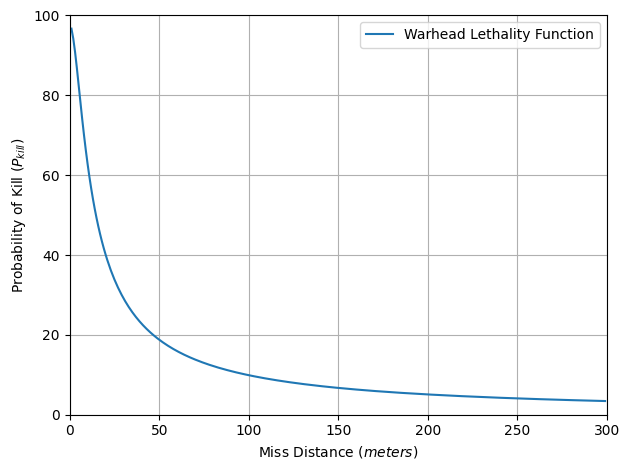

In [11]:
import matplotlib.pyplot as plt
x = []
y = []
for i in range(1,300):
    x.append(i)
    y.append(calculate_pkill(i))
    #print(f"Miss distance {i}: {calculate_pkill(i)}")
plt.figure()
plt.grid()
plt.plot(x,y)
plt.xlim(0, 300)
plt.ylim(0, 100)
plt.xlabel('Miss Distance ($meters$)')
plt.ylabel('Probability of Kill ($P_{kill}$)')
plt.legend([ 'Warhead Lethality Function'])
plt.tight_layout()
#plt.savefig('figures/pkill_eps.eps', format='eps')
#plt.savefig('figures/pkill_400dpi.png', format='png', dpi=400)

<Axes: ylabel='Frequency'>

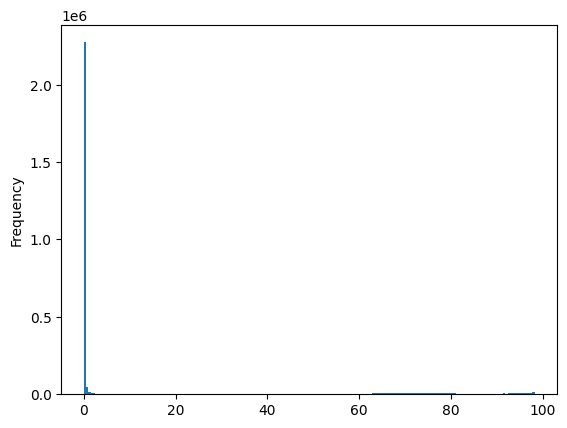

In [12]:
df['pkill'].plot.hist(bins=200)

In [13]:
df

,alt_sht,vel_sht,alt_tgt,vel_tgt,dist,pit_sht,sin(hdg_tgt),cos(hdg_tgt),sin(rgt_tgt),cos(rgt_tgt),turn_dg,delay,miss_dist,pkill
0,1900.094833,516.257515,9411.674491,389.059516,22.107204,-9.115002,-0.008574,-0.999963,0.472136,0.881526,5.107690,24.962478,12840.388130,0.081
1,1668.030968,384.114554,6424.170046,538.332386,42.957053,-9.291737,0.491448,-0.870907,0.368705,0.929546,140.635249,27.889110,68935.014560,0.015
2,1430.046650,552.946387,11292.969864,536.495037,17.904767,-16.802029,-0.946979,0.321295,0.732540,0.680724,13.967480,28.814680,15869.019903,0.066
3,1819.812543,524.681447,3983.583185,354.232941,38.858097,2.326836,-0.535011,-0.844845,-0.429737,0.902954,47.110727,25.736859,55065.305561,0.019
4,1348.600786,367.370819,8269.417066,533.015720,27.176054,13.801087,0.996601,0.082385,-0.734047,0.679098,137.619306,17.912385,47172.155816,0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855050,44376.436551,544.473934,16868.508237,620.848721,32.909110,-4.773440,0.992877,0.119143,0.537314,0.843382,71.510008,21.978916,36040.502363,0.029
2855051,44396.062176,555.458863,44331.857296,626.047542,42.962424,-12.651975,0.471726,0.881745,-0.438462,0.898750,145.538436,27.934929,45979.441460,0.023
2855052,44373.716110,609.965112,16754.178594,580.015564,43.350364,-24.517640,0.196996,-0.980404,-0.284867,0.958567,79.534893,15.081863,25623.383672,0.041
2855053,44432.347726,617.846742,24860.378262,658.322238,40.760772,11.024131,-0.566162,-0.824294,0.249802,0.968297,84.072836,26.462078,9995.672595,0.104


<Axes: ylabel='Frequency'>

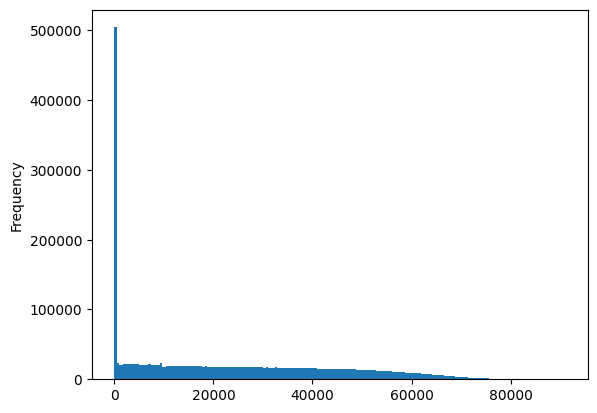

In [14]:
df['miss_dist'].plot.hist(bins=200)

In [15]:
df['kill'] = df['pkill'].apply(lambda x: True if x >= 50 else False)
df['kill'].value_counts()

kill
False    2379828
True      475227
Name: count, dtype: int64

In [16]:
round(df['pkill'].describe(),2)

count    2855055.00
mean          13.33
std           29.77
min            0.01
25%            0.02
50%            0.05
75%            0.21
max           98.23
Name: pkill, dtype: float64

In [17]:
df

,alt_sht,vel_sht,alt_tgt,vel_tgt,dist,pit_sht,sin(hdg_tgt),cos(hdg_tgt),sin(rgt_tgt),cos(rgt_tgt),turn_dg,delay,miss_dist,pkill,kill
0,1900.094833,516.257515,9411.674491,389.059516,22.107204,-9.115002,-0.008574,-0.999963,0.472136,0.881526,5.107690,24.962478,12840.388130,0.081,False
1,1668.030968,384.114554,6424.170046,538.332386,42.957053,-9.291737,0.491448,-0.870907,0.368705,0.929546,140.635249,27.889110,68935.014560,0.015,False
2,1430.046650,552.946387,11292.969864,536.495037,17.904767,-16.802029,-0.946979,0.321295,0.732540,0.680724,13.967480,28.814680,15869.019903,0.066,False
3,1819.812543,524.681447,3983.583185,354.232941,38.858097,2.326836,-0.535011,-0.844845,-0.429737,0.902954,47.110727,25.736859,55065.305561,0.019,False
4,1348.600786,367.370819,8269.417066,533.015720,27.176054,13.801087,0.996601,0.082385,-0.734047,0.679098,137.619306,17.912385,47172.155816,0.022,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855050,44376.436551,544.473934,16868.508237,620.848721,32.909110,-4.773440,0.992877,0.119143,0.537314,0.843382,71.510008,21.978916,36040.502363,0.029,False
2855051,44396.062176,555.458863,44331.857296,626.047542,42.962424,-12.651975,0.471726,0.881745,-0.438462,0.898750,145.538436,27.934929,45979.441460,0.023,False
2855052,44373.716110,609.965112,16754.178594,580.015564,43.350364,-24.517640,0.196996,-0.980404,-0.284867,0.958567,79.534893,15.081863,25623.383672,0.041,False
2855053,44432.347726,617.846742,24860.378262,658.322238,40.760772,11.024131,-0.566162,-0.824294,0.249802,0.968297,84.072836,26.462078,9995.672595,0.104,False


<Axes: ylabel='Frequency'>

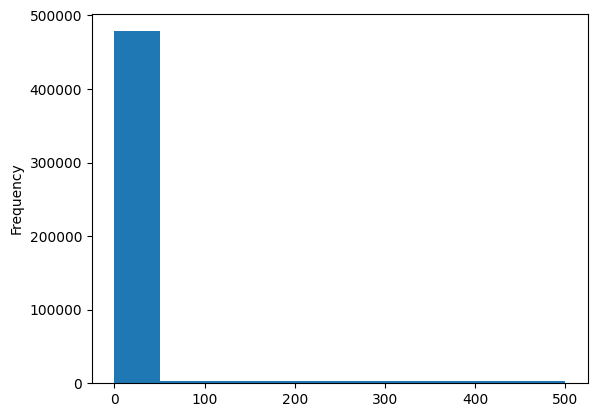

In [18]:
df_500 = df[df['miss_dist']<=500]
df_500['miss_dist'].plot.hist()

In [19]:
round(df.describe(), 2)

,alt_sht,vel_sht,alt_tgt,vel_tgt,dist,pit_sht,sin(hdg_tgt),cos(hdg_tgt),sin(rgt_tgt),cos(rgt_tgt),turn_dg,delay,miss_dist,pkill
count,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00
mean,21134.88,513.80,19918.72,470.47,25.00,0.00,0.00,0.00,0.00,0.83,89.98,22.50,24739.83,13.33
std,10842.30,73.84,11573.54,94.33,11.55,17.32,0.71,0.71,0.54,0.15,51.97,4.33,20805.19,29.77
min,1000.00,300.00,1000.01,300.00,5.00,-30.00,-1.00,-1.00,-0.87,0.50,0.00,15.00,0.00,0.01
25%,12367.06,462.20,10282.47,393.10,15.01,-15.00,-0.71,-0.71,-0.50,0.71,44.96,18.75,4881.81,0.02
50%,21503.77,523.89,18973.59,469.85,24.99,-0.01,0.00,0.00,0.00,0.87,90.01,22.50,21780.30,0.05
75%,29201.76,572.36,28622.25,544.19,35.01,15.01,0.71,0.71,0.50,0.97,134.97,26.26,41171.43,0.21
max,44999.87,653.48,44999.95,700.00,45.00,30.00,1.00,1.00,0.87,1.00,180.00,30.00,91069.93,98.23


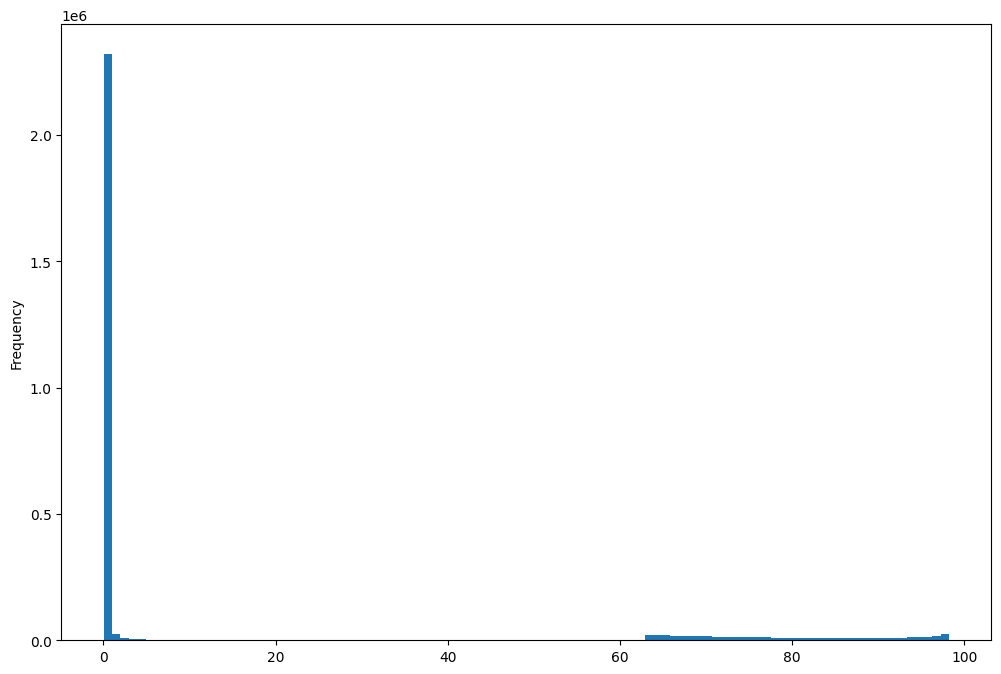

In [20]:
df['pkill'].plot.hist(figsize=(12,8), bins=100);

In [21]:
round(df['pkill'].describe(),2)

count    2855055.00
mean          13.33
std           29.77
min            0.01
25%            0.02
50%            0.05
75%            0.21
max           98.23
Name: pkill, dtype: float64

In [22]:
df2 = df[df['pkill']>=0.05]

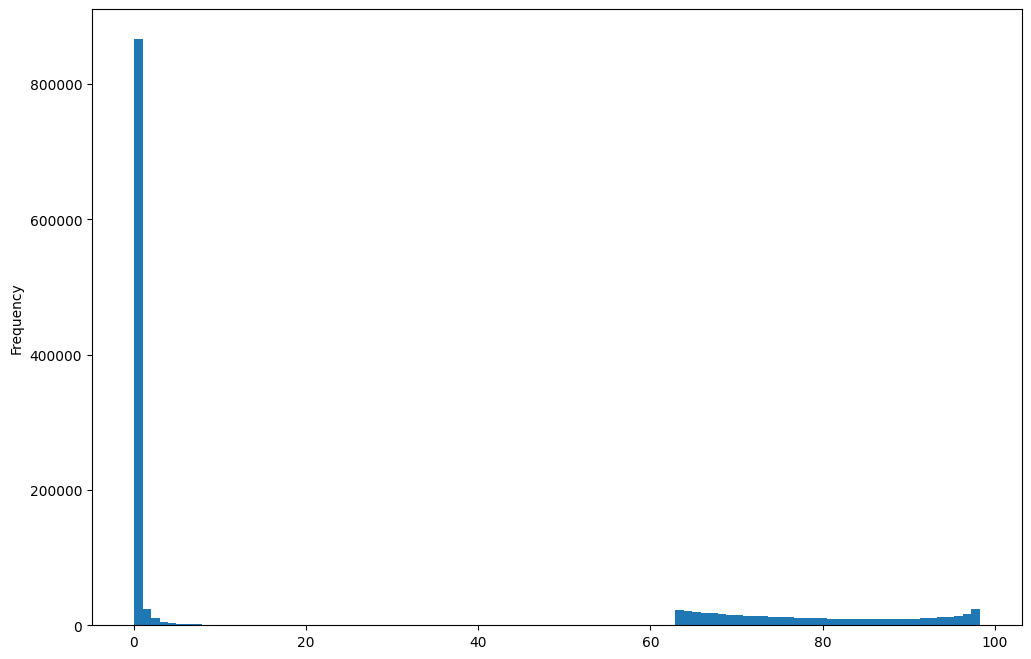

In [23]:
df2['pkill'].plot.hist(figsize=(12,8), bins=100);

In [24]:
calculate_pkill(20805.19)

0.05

In [25]:
round(df2['pkill'].describe(),2)

count    1399539.00
mean          27.16
std           37.84
min            0.05
25%            0.08
50%            0.23
75%           69.20
max           98.23
Name: pkill, dtype: float64